In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive/')
import seaborn as sns

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import re

In [ ]:
pd.set_option('display.max_columns',None,'display.max_rows',None)

In [ ]:
def read_dataframe(path):
  df=pd.read_excel(path)
  #df.drop(['pdf','href formula','href','Case Number','Case Number.1','original order','Unnamed: 21','Unnamed: 22'],axis=1,inplace=True)
  df.rename(columns={'Species ':'Species','Unnamed: 11':'Fatality'},inplace=True)
  df=df.iloc[:6906]

  return df

In [ ]:
def mass_replace(df,column,matches_replacements):
  '''
  Replaces every key from matches_replacements dict with the corresponding value

  '''
  if not len(matches_replacements):
    raise ValueError('Length of arguments 0. Please give something to replace')

  if type(matches_replacements) != dict:
    raise TypeError('Matches_replacements must be of type dict')

  types=[list,tuple,dict]
  for key,value in matches_replacements.items():
    if type(key) in types or type(value) in types:
      raise TypeError('''When iterating through keys and values, none of the
      individual keys or values should be an interable''')

    try:
      df[column].replace({key:value},regex=True,inplace=True)

    except:
      print(f'the key, value causing the error are {key},{value}')



In [ ]:
def clean_sex_column(df):
  pattern1=r'&|passengers|crew\b|occupants|males\b|Occupants|people|men\b|children|others?\b|migrants|immigrants|couple\b|refugees\b|slaves|poachers|tourists|swimmers'
  mask=df.Name.str.contains(pattern1,regex=True)
  df.Sex[(mask)&(df.Sex.isnull())]='multiple'

  return df

In [ ]:
def give_enumerated_dict_from_list(list_of_words):


  dictionary_of_word_index={}

  for i,word in enumerate(list_of_words):
    dictionary_of_word_index[word]=i

  return dictionary_of_word_index



def remove_stopwords(string):
  if pd.isna(string):
    string=''
  if type(string) != str:
    raise ValueError(f'object is of type {type(string)}, object is {string}')

  tokenized_list=nltk.word_tokenize(string)

  stopwords_dict=give_enumerated_dict_from_list(stopwords.words('english'))
  tokenized_dict=give_enumerated_dict_from_list(tokenized_list)

  no_stopwords_list=[]
  for word in tokenized_dict.keys():
    if not stopwords_dict.get(word,False):
      no_stopwords_list.append(word)


  return no_stopwords_list

def pos_tag_verb_selection(string):
  string=remove_stopwords(string)

  tagged_string=nltk.pos_tag(string)

  list_of_only_verbs=[]

  for word,pos in dict(tagged_string).items():
    if 'V' in pos:
      list_of_only_verbs.append(word)

  list_of_only_lemma=[]

  for word in list_of_only_verbs:
    list_of_only_lemma.append(lemmatizer.lemmatize(word.lower(),'v'))

  return list_of_only_lemma



In [ ]:
def len_detect_before_split(word_list):
  if len(word_list)>1:
    return ','.join(word_list)
  elif len(word_list)==1:
    return word_list[0]
  else:
    return np.nan

In [ ]:
def name_cleaner(string):
  if type(string)!=str:
    return np.nan

  try:
    string=string.lower()
    string= string.split(' ')
    return string[0]
  except:
    print(string)
    return np.nan

In [ ]:
df=read_dataframe('/content/drive/My Drive/GSAF5.xls')

In [ ]:
df.shape

(6906, 23)

In [ ]:
mass_replace(df,'Sex',{r'.*M.*':'M','lli':'M',r'\.': np.nan,'N':'M'})

In [ ]:
df[df.Species.str.contains('Old Tom')==True]

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,Injury,Fatality,Time,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
5927,Reported 26-Sep-1914,1914.0,Unprovoked,JAMAICA,Kingston Parish,Port Royal,Fell overboard,"""a native boy""",M,NaN,FATAL,Y,NaN,"A 20' shark known as ""Old Tom""","Stevens Point Daily Journal, 9/26/1914, p.2",1914.09.26.R-Jamaica.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,1914.09.26.R,1914.09.26.R,979.0,NaN,NaN


In [ ]:
df=clean_sex_column(df)

<ipython-input-63-009b7c963262>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
lemmatizer=WordNetLemmatizer()

In [ ]:
# activity

In [ ]:
df['Activity_tokens']=df.Activity.apply(pos_tag_verb_selection)

In [ ]:
df['Activities_token_strings']=df.Activity_tokens.apply(len_detect_before_split)

In [ ]:
activities_series=df.Activities_token_strings.value_counts()

In [ ]:
activities_dict={}
for index,value in zip(activities_series.index,activities_series.values):
  if len(index.split(','))==1:
    if activities_dict.get(index,False):
      activities_dict[index]+=value
    else:
      activities_dict[index]=value
  if len(index.split(','))>1:
    for word in index.split(','):
      if activities_dict.get(word,False):
        activities_dict[word]+=value
      else:
        activities_dict[word]=value

In [ ]:
activities_df=pd.Series(activities_dict).sort_values(ascending=False).reset_index()

In [ ]:
activities_df=activities_df[activities_df[0]>8]

In [ ]:
activities_df['index'].iloc[5]='wade'
activities_df['index'].iloc[6]='bathe'
activities_df[0].iloc[5]+=activities_df[0].iloc[7]
activities_df[0].iloc[4]+=activities_df[0].iloc[8]
activities_df[0].iloc[0]+=activities_df[0].iloc[9]
activities_df[0].iloc[12]+=activities_df[0].iloc[10]
activities_df[0].iloc[12]+=activities_df[0].iloc[21]
activities_df.drop([7,8,9,10,21,11,15,18,19,20,22,23,24,27,28,29,30,31,33,34,35,37,38,40,41,43,44,45,46,47,51,52],axis=0,inplace=True)


<ipython-input-82-25d72a8ab005>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-82-25d72a8ab005>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-82-25d72a8ab005>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-82-25d72a8ab005>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [ ]:
activities_df=activities_df.sort_values(by=0,ascending=False).reset_index().drop(['level_0'],axis=1)
activities_df.rename(columns={'index':'Activity',0:'Count'},inplace=True)

In [ ]:
activities_df.drop([16,17,18,19,20],inplace=True)

In [ ]:
mass_replace(df,'Time',{r'oo':'00',r'A':'',r'(?i)mid':'',r'(?i)late':'',
                        r'(?i)early':'',
                        r' (?i)(Sunset)':'',
                        r'(?i)fall':'',
                        r'(?i)Morning':'09:50',
                        r'(?i)M':'09:50',
                        r'(?i)A.M.':'09:50',
                        r'(?i)Before ':'',
                        r'(?i)shortly ':'',
                        r'(?i)Prior to ':'',
                        r'(?i)After ':'',
                        r'(?i)Just ':'',
                        r'(?i)daybreak':'06:00',
                        r'(?i)evening':'18:00',
                        r'(?i)sundown':'18:00',
                        r'(?i)sunset':'18:00',
                        r'" (?i)evening"':'18:00',
                        r'(?i)dusk':'18:00',
                        r'(?i)dawn':'06:00',
                        r'(?i)Night':'21:00',
                        r'(?i)Dark':'21:00',
                        r'(?i)h':':',
                        r'(?i)Afternoon':'14:00',
                        r'(?i)Afternon':'14:00',
                        r'(?i)Midday':'12:00',
                        r'(?i)noon':'12:00',
                        r'(?i)day.':'12:00',
                        r'(?i)day':'12:00',
                        r'(?i)Between (\d\d:\d\d) and (\d\d:\d\d)':'\\1',
                        r'(?i)Between (\d\d:\d\d) to (\d\d:\d\d)':'\\1',
                        r'(\d\d:\d\d) to (\d\d:\d\d)':'\\1',
                        r'(\d\d)(\d\d)':'\1:\\2',
                        r'(?i)Between (\d\d:\d\d) & (\d\d:\d\d)':'\\1',
                        r'(\d\d:\d\d)-{1,2}\d\d:\d\d':'\\1',
                        r'(\d\d:\d\d) - \d\d:\d\d':'\\1',
                        r'(\d\d:\d\d) -\d\d:\d\d':'\\1',
                        r'(\d\d:\d\d) -- \d\d:\d\d':'\\1',
                        r'(\d\d:\d\d) or \d\d:\d\d':'\\1',
                        r'(\d\d:\d\d) / \d\d:\d\d':'\\1',
                        r'(\d\d:\d\d)\(\d\d:\d\d\)':'\\1',
                        r'" ':'',
                        r'"':'',
                        r'P\.':'',
                        r'\.':'',
                        r'>':'',
                        r'<':'',
                        r'j':'',
                        r'-':'',
                        r'`':'',
                        r' ':'',
                        r'':''})

In [ ]:
df.Time.iloc[5600]=np.nan
df.Time.iloc[5308]='03:10'
df.Time.iloc[5289]='11:01'
df.Time.iloc[5208]='18:00'
df.Time.iloc[5057]=np.nan
df.Time.iloc[4988]='21:00'
df.Time.iloc[4187]='13:00'
df.Time.iloc[4030]=np.nan
df.Time.iloc[3667]='09:50'
df.Time.iloc[3291]=np.nan
df.Time.iloc[3124]=np.nan
df.Time.iloc[2764]=np.nan
df.Time.iloc[2603]=np.nan
df.Time.iloc[1692]='15:45'
df.Time.iloc[1675]='12:00'
df.Time.iloc[1535]='09:50'
df.Time.iloc[1050]='06:00'
df.Time.iloc[613]='19:00'
df.Time.iloc[328]='14:15'





<ipython-input-86-bacd450ef7f4>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-86-bacd450ef7f4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-86-bacd450ef7f4>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-86-bacd450ef7f4>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [ ]:
mass_replace(df,'Age',{r'(\d{1,2}) or \d{1,2}':'\g<1>',
        r'(\d{1,2}) to \d{1,2}':'\g<1>',
        r'"?(?i)young"?':np.nan,
        r'"?(?i)adult"?':np.nan,
        r'"?(?i)elderly"?':np.nan,
        r"\d+'?s":np.nan,
        r'(?i)m':np.nan,
        r'(?i)teens?':np.nan,
        r'[1-9]{1,2} and [1-9]{1,2}':'-1',
        r'.* and .*':'-1',
        r'.* & .*':'-1',
        r'>':'',
        r'<':'',
        r'\d      &    \d\d':'-1',
        r' ':'',
        r'\?':''})


In [ ]:
df.Age.iloc[6599]=2
df.Age.iloc[5775]=2
df.Age.iloc[5764]=np.nan
df.Age.iloc[5678]=np.nan
df.Age.iloc[5655]=np.nan
df.Age.iloc[5593]='-1'
df.Age.iloc[5394]='-1'
df.Age.iloc[5269]=np.nan
df.Age.iloc[5180]='-1'
df.Age.iloc[4983]=np.nan
df.Age.iloc[4803]=1
df.Age.iloc[4708]='-1'
df.Age.iloc[4668]='-1'
df.Age.iloc[4654]=np.nan
df.Age.iloc[4642]=np.nan
df.Age.iloc[4588]='-1'
df.Age.iloc[4576]='-1'
df.Age.iloc[4392]=np.nan
df.Age.iloc[4236]=np.nan
df.Age.iloc[4136]=1
df.Age.iloc[4107]='-1'
df.Age.iloc[3837]=20
df.Age.iloc[3739]=74
df.Age.iloc[3740]=45
df.Age.iloc[3693]=np.nan
df.Age.iloc[3567]=np.nan
df.Age.iloc[3550]=np.nan
df.Age.iloc[3477]=np.nan
df.Age.iloc[3215]=np.nan
df.Age.iloc[3216]=np.nan
df.Age.iloc[3075]=np.nan
df.Age.iloc[2533]=np.nan
df.Age.iloc[2479]=6
df.Age.iloc[2402]=np.nan
df.Age.iloc[2403]=np.nan
df.Age.iloc[1023]=1
df.Age.iloc[554]=np.nan
df.Age.iloc[424]='-1'
df.Age.iloc[202]=np.nan
df.Age.iloc[198]=6
df.Age.iloc[36]=2
df.Age.iloc[16]=np.nan




<ipython-input-88-521be689f29c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-88-521be689f29c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-88-521be689f29c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-88-521be689f29c>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [ ]:
df.Name=df.Name.apply(name_cleaner)

In [ ]:
name_counts=df.Name.value_counts().reset_index().drop([0,1,3,7,12,21,22])

In [ ]:
name_counts.rename(columns={'index':'name','Name':'count'},inplace=True)

In [ ]:
name_counts=name_counts[name_counts['count']>28]

In [ ]:
name_counts.shape

(16, 2)

In [ ]:
df.Age=df.Age.astype(float)

Text(0, 0.5, '')

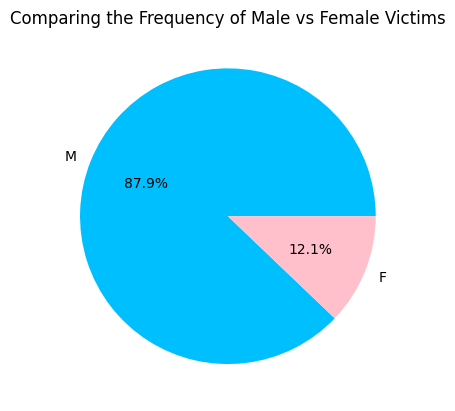

In [ ]:
plt.pie(labels=df.Sex[df.Sex!='multiple'].value_counts().index,x=df.Sex[df.Sex!='multiple'].value_counts().values,
  colors=['deepskyblue','pink'],autopct='%1.1f%%')
plt.title('Comparing the Frequency of Male vs Female Victims')
plt.xlabel('')
plt.ylabel('')

In [ ]:
def check_token_strings(check_me,activities=list(activities_df.Activity.values)):
  if type(check_me) != str:
    return np.nan
  if check_me in activities:
    return check_me

  else:
    return np.nan

In [ ]:
def splitter(string):
  if string!= string:
    return np.nan
  if string == '':
    return np.nan
  string=str(string)
  tme=string.split(':')[0]
  #try :
    #if int(tme) > 12:
      #print(time)
      #time= int(time)-12
      #time=str(time)
      #pass
    #elif int(tempfile)==0:
      #time=12
      #pass
      #tme = str(tme)
  #except:
    #return np.nan
  tme= tme+':00'
  return tme

df.Time=df.Time.apply(splitter)

for time in df.Time:

  try:
    pd.to_datetime(time)
  except:
    try:
      df.Time[df.Time==str(time)]=np.nan
    except:
      raise ValueError('ugh')

<ipython-input-97-5a3b6a2fea13>:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df.Time=pd.to_datetime(df.Time,format='%H:%M').dt.time

In [ ]:
df.Activities_token_strings=df.Activities_token_strings.apply(check_token_strings)
time_counts=df.Time.value_counts().reset_index().rename(columns={'index':'Time','Time':'Count'}).sort_values(by='Time',ascending=True)
#time_counts=time_counts[time_counts.Count > 30]

In [ ]:
import plotly.express as px
from datetime import time
time_counts_before_noon=time_counts[time_counts['Time'] < time(12, 0, 0)]
time_counts_after_noon=time_counts[time_counts['Time']>= time(12,0,0)]
fig_before_noon = px.bar_polar(time_counts_before_noon, r='Count', theta='Time',
                   category_orders={'Time': time_counts_before_noon['Time'].values},
                   color_discrete_sequence=['teal'])



fig_before_noon.update_layout(
                              polar=dict(radialaxis=dict(visible=True,range=[0, 400])))

fig_before_noon.show()

In [ ]:
fig_after_noon = px.bar_polar(time_counts_after_noon, r='Count', theta='Time',
                   category_orders={'Time': time_counts_after_noon['Time'].values},
                   color_discrete_sequence=['teal'])
fig_after_noon.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 400])))
fig_after_noon.show()

In [ ]:

fig = px.bar_polar(time_counts, r='Count', theta='Time',
                   category_orders={'Time': time_counts['Time'].values},
                   color_discrete_sequence=['teal'])



fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 400])))

fig.show()

In [ ]:
time_counts=time_counts.reset_index().drop('index',axis=1)